In [1]:
import numpy as np
import pandas as pd
import feather
import os, sys, random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # to ensure console display all columns
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_row', 50)
plt.style.use('ggplot')
from pathlib import Path

project = 'Greyhound_Competition'
projectPath = Path(r'E:/Projects') / f"{project}"
os.chdir(projectPath)
sys.path.append(str(projectPath))

dataPath = projectPath / 'data'
pickleDataPath = dataPath / 'pickle'
htmlDataPath = dataPath / 'html'
imageDataPath = dataPath / 'image'
dataInputPath = dataPath / 'input'
dataWorkingPath = dataPath / 'working'
dataOutputPath = dataPath / 'output'
modelPath = projectPath / 'models'

import pickle
def save_obj(obj, name):
    with open(pickleDataPath / f'{name}.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(pickleDataPath / f'{name}.pkl', 'rb') as f:
        return pickle.load(f)

Imports

In [2]:
import tensorflow as tf
print(tf.__version__)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

2.9.1


Settings

In [3]:
col_feature = [str(x) for x in list(range(62))]
N = len(col_feature)
n_traps = 6
input_file = f"upwork_data2.csv"

Compare baseline model versus optimized model over multiple seeds

In [4]:
df = pd.read_csv(dataInputPath / input_file)
df = df[df.trap <= 6]

def group_horse_and_result(element):
    if element[0] == 'finish':
        return 100 + element[1] # to make sure finish resuls are put near the end
    else:
        return element[1]

df = df.pivot(index = 'race_id', columns = 'trap', values = df.columns[2:])
rearranged_columns = sorted(list(df.columns.values), key = group_horse_and_result)
df = df[rearranged_columns]
df.dropna(inplace = True)
X = df[df.columns[:-6]]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
y_won = df[df.columns[-6:]].applymap(lambda x: 1 if x == 1 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y_won, train_size=0.8, test_size=0.2, random_state=1)
train_id_list = list(y_train.index)
test_id_list = list(y_test.index)
train_df = df.loc[train_id_list]
test_df = df.loc[test_id_list]

multi_input_accuracy = []
multi_input_precision = []
baseline_accuracy = []
baseline_precision = []
for model_type in ['baseline','multi_input']:
    for i in range(100):
        print(f"model_type: {model_type}, seed: {i}")
        set_seed(i)

        if model_type == 'baseline':
            input = Input(shape=(X_train.shape[1], ))
            m = Dense(128, activation='relu')(input)
            m = Dropout(0.5)(m)
            m = Dense(n_traps, activation="softmax")(m)
            model = Model(inputs=input, outputs=m)

            model.compile(
                optimizer=tf.keras.optimizers.Adam(lr=0.005),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['acc', tf.keras.metrics.Precision(name='precision')],
            )

            callback = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

            dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            train_dataset = dataset.shuffle(len(X_train)).batch(500)
            dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            validation_dataset = dataset.shuffle(len(X_test)).batch(500)
            history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, callbacks=[callback], verbose=0)
            test_loss, test_acc, test_precision = model.evaluate(X_test.values, y_test.values, batch_size=512, verbose=0)
            baseline_accuracy += [test_acc]
            baseline_precision += [test_precision]

        if model_type == 'multi_input':
            act = 'relu'

            def get_MLP_input_layer(N, act):
                input = Input(shape=(N,))

                x = Dense(32, activation=act)(input)
                x = Dropout(0.2)(x)

                x = Dense(32, activation=act)(x)
                x = Dropout(0.2)(x)

                x = Dense(16, activation=act)(x)
                #x = Dropout(0.2)(x)

                x = Model(inputs=input, outputs=x)

                return x

            concat_list = []
            for i in range(n_traps):
                concat_list += [get_MLP_input_layer(N, act)]

            combined = concatenate([x.output for x in concat_list])

            m = Dense(32, activation=act)(combined)
            #m = BatchNormalization()(m)

            m = Dense(32, activation=act)(m)
            m = BatchNormalization()(m)

            m = Dense(n_traps, activation="softmax")(m)
            model = Model(inputs=[x.input for x in concat_list], outputs=m)

            model.compile(
                optimizer=tf.keras.optimizers.Adam(lr=0.005),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['acc', tf.keras.metrics.Precision(name='precision')],
            )

            early_stop = EarlyStopping(monitor='val_acc', min_delta=0,
                                       patience=50, verbose=0, mode='auto',
                                       baseline=0, restore_best_weights=True)

            history = model.fit([train_df.xs(i, level="trap", axis=1)[col_feature].values for i in range(1, n_traps+1)],
                                y_won.loc[train_id_list].values,
                                epochs=1000,
                                batch_size=1028,
                                validation_data=([test_df.xs(i, level="trap", axis=1)[col_feature].values for i in range(1, n_traps+1)],
                                                 y_won.loc[test_id_list].values),
                                shuffle=True, verbose=0,
                                callbacks=[early_stop])

            test_loss, test_acc, test_precision = model.evaluate([test_df.xs(i, level="trap", axis=1)[col_feature].values for i in range(1, n_traps+1)],
                                                                 y_won.loc[test_id_list].values,
                                                                 batch_size=1028,
                                                                 verbose=0)

            multi_input_accuracy += [test_acc]
            multi_input_precision += [test_precision]


model_type: baseline, seed: 0
model_type: baseline, seed: 1
model_type: baseline, seed: 2
model_type: baseline, seed: 3
model_type: baseline, seed: 4
model_type: baseline, seed: 5
model_type: baseline, seed: 6
model_type: baseline, seed: 7
model_type: baseline, seed: 8
model_type: baseline, seed: 9
model_type: baseline, seed: 10
model_type: baseline, seed: 11
model_type: baseline, seed: 12
model_type: baseline, seed: 13
model_type: baseline, seed: 14
model_type: baseline, seed: 15
model_type: baseline, seed: 16
model_type: baseline, seed: 17
model_type: baseline, seed: 18
model_type: baseline, seed: 19
model_type: baseline, seed: 20
model_type: baseline, seed: 21
model_type: baseline, seed: 22
model_type: baseline, seed: 23
model_type: baseline, seed: 24
model_type: baseline, seed: 25
model_type: baseline, seed: 26
model_type: baseline, seed: 27
model_type: baseline, seed: 28
model_type: baseline, seed: 29
model_type: baseline, seed: 30
model_type: baseline, seed: 31
model_type: baseli

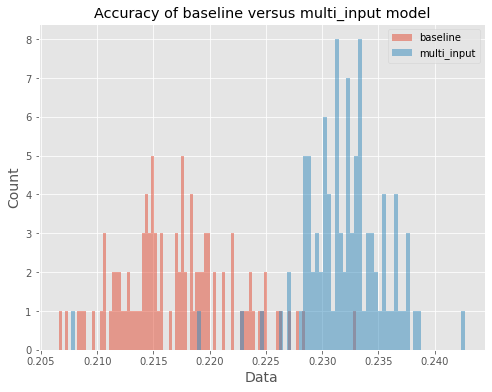

In [5]:
plt.figure(figsize=(8,6))
plt.hist(baseline_accuracy, bins=100, alpha=0.5, label="baseline")
plt.hist(multi_input_accuracy, bins=100, alpha=0.5, label="multi_input")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Accuracy of baseline versus multi_input model")
plt.legend(loc='upper right')
plt.show()

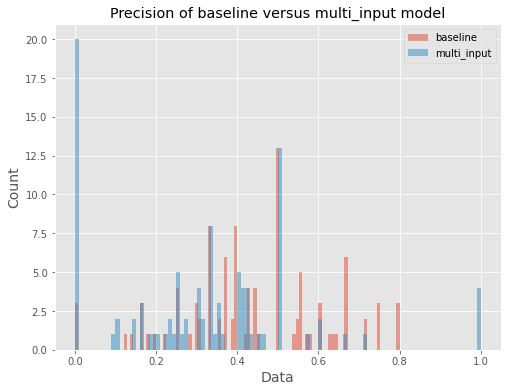

In [6]:
plt.figure(figsize=(8,6))
plt.hist(baseline_precision, bins=100, alpha=0.5, label="baseline")
plt.hist(multi_input_precision, bins=100, alpha=0.5, label="multi_input")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Precision of baseline versus multi_input model")
plt.legend(loc='upper right')
plt.show()